<a href="https://colab.research.google.com/github/unofficial-Jona/XAI-Group/blob/master/XAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [206]:
df = pd.read_csv('initialized_dataset')
df

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,date,sum_click
0,0,Distinction,89.65,1.000,103.457907,2.706754
1,0,Pass,84.58,1.000,87.617265,1.539047
2,0,Pass,51.44,0.625,49.181286,1.562619
3,0,Pass,75.13,1.000,118.698642,2.189217
4,0,Distinction,93.22,1.000,75.791987,2.100617
...,...,...,...,...,...,...
4945,0,Pass,87.30,1.000,122.839227,1.322085
4946,0,Pass,81.80,1.000,63.128534,1.564681
4947,0,Pass,80.05,1.000,92.756349,1.615318
4948,0,Pass,65.75,1.000,128.453230,1.975989


# data split

In [207]:
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
train, test = model_selection.train_test_split(df, test_size=0.2)


# data preprocessing



In [208]:
class PrepareDataset(BaseEstimator, TransformerMixin):
    def __init__(self, prepare_nn=False):
        self.prepare_nn = prepare_nn
    def fit(self, X):
        return self
    def transform(self, X):
        y = X['final_result']
        y = np.where(y == 'Distinction', 1, y)
        y = np.where(y == 'Pass', 1, y)
        y = np.where(y == 'Fail', 0, y)
        y = y.astype('bool')
        X = X.drop('final_result', axis=1)
        if self.prepare_nn:
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
            return X, y
        else:
            return X, y



In [209]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

In [210]:
data_prep = PrepareDataset(prepare_nn=True)
X_train, y_train = data_prep.transform(train)
X_train.shape, y_train.shape

((3960, 5), (3960,))

In [211]:
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((6860, 5), (6860,))

In [212]:
y_train

array([ True,  True,  True, ..., False, False, False])

# model set up

## SVC

In [213]:
from sklearn.svm import SVC

clf_SVC = SVC(kernel='linear', probability=True)
clf_SVC.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## random forest

In [214]:
from sklearn.ensemble import RandomForestClassifier


clf_RanFor = RandomForestClassifier()
clf_RanFor.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## MLP

In [215]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


clf_MLP = MLPClassifier(random_state=1, max_iter=300)
clf_MLP.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

# assess accuracy (train data)


## SVC

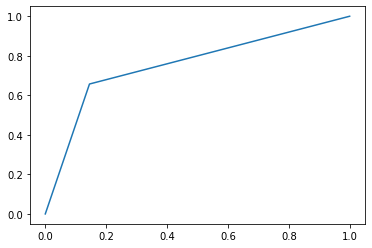

In [216]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(clf_SVC, X_train, y_train, cv=3)

fpr, tpr, threshold = roc_curve(y_train, y_scores)
plt.plot(fpr,tpr)

In [217]:
roc_auc_score(y_train, y_scores)

0.7559766763848396

In [218]:
confusion_matrix(y_train, y_scores)

array([[2932,  498],
       [1176, 2254]])

## random forest

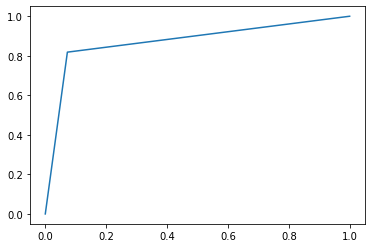

In [219]:
y_scores = cross_val_predict(clf_RanFor, X_train, y_train, cv=3)

fpr, tpr, threshold = roc_curve(y_train, y_scores)
plt.plot(fpr, tpr)

In [220]:
roc_auc_score(y_train, y_scores)

0.8728862973760934

In [221]:
confusion_matrix(y_train, y_scores)

array([[3181,  249],
       [ 623, 2807]])

## MLP

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


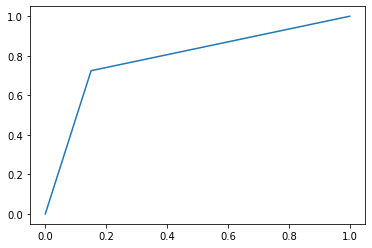

In [222]:
y_scores = cross_val_predict(clf_MLP, X_train, y_train, cv=3)

fpr, tpr, threshold = roc_curve(y_train, y_scores)
plt.plot(fpr, tpr)

In [223]:
roc_auc_score(y_train, y_scores)

0.7870262390670554

In [224]:
confusion_matrix(y_train, y_scores)

array([[2914,  516],
       [ 945, 2485]])

# assess accuracy (test data)

In [225]:
X_test, y_test = data_prep.transform(test)
X_test, y_test = sm.fit_resample(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## SVC

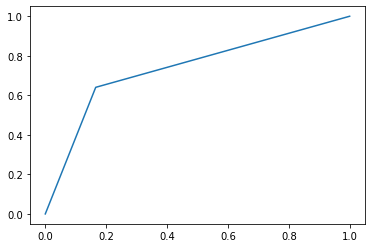

In [226]:
y_scores = clf_SVC.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr)

In [227]:
roc_auc_score(y_test, y_scores)

0.737367802585194

In [228]:
confusion_matrix(y_test, y_scores)

array([[710, 141],
       [306, 545]])

## random forest


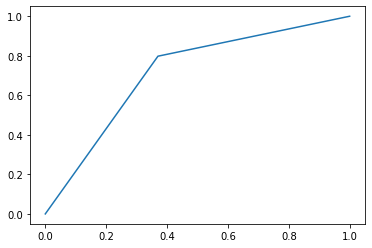

In [229]:
y_scores = clf_RanFor.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr)

In [230]:
roc_auc_score(y_test, y_scores)

0.7138660399529965

In [231]:
confusion_matrix(y_test, y_scores)

array([[536, 315],
       [172, 679]])

## MLP

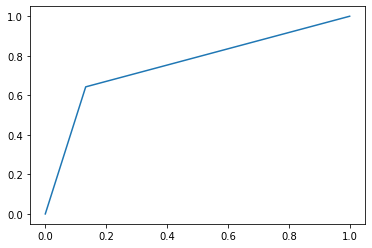

In [232]:
y_scores = clf_MLP.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr)

In [233]:
roc_auc_score(y_test, y_scores)

0.754994124559342

In [234]:
confusion_matrix(y_test, y_scores)

array([[738, 113],
       [304, 547]])

# XAI methods

In [237]:
! pip install lime

     |████████████████████████████████| 276kB 9.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=c37ecaf53def6a6eefc262c474be1ee769bdc4fdfb1eb118f78c0fff47d8924e
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## LIME

In [242]:
from lime import lime_tabular

def run_lime(classifier, sample):
  explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=['Fail', 'Pass'],
        mode='classification'
    )
  exp = explainer.explain_instance(
        data_row=sample,
        predict_fn=classifier.predict_proba
    )
  return exp.show_in_notebook(show_table = True)
  

In [244]:
instance = X_test[1]
run_lime(clf_SVC, instance)

AttributeError: ignored